# BBC News Classification using NMF 

### Kaggle link: https://www.kaggle.com/code/venkatabotta/bbc-news-classification

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
import operator
import random
import sklearn
import sklearn.linear_model
import sklearn.model_selection
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer,ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report, make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Introduction

### For this project, we will use NMF method to classify the various articles present the dataset into 5 main categories/clusters. 

### We will first import the train and test set data for our basic explanatroy data analysis procedure and to get insights from by extracting important variables from our train dataset.


In [2]:
bbc_train = pd.read_csv('bbc_train.csv')
bbc_test = pd.read_csv('bbc_test.csv')

## Step 1 : Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 

### Inspect the train dataset

In [3]:
bbc_train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


### Word count of each article in the train data.

In [4]:
bbc_train['word_count'] = bbc_train['Text'].apply(lambda n: len(n.split()))

In [5]:
bbc_train.head()

,ArticleId,Text,Category,word_count
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301
1,154,german business confidence slides german busin...,business,325
2,1101,bbc poll indicates economic gloom citizens in ...,business,514
3,1976,lifestyle governs mobile choice faster bett...,tech,634
4,917,enron bosses in $168m payout eighteen former e...,business,355


### Locate missing data in the train dataset. 

In [6]:
bbc_train.isnull().sum()

ArticleId     0
Text          0
Category      0
word_count    0
dtype: int64

### Check for duplicates in the train dataset

In [7]:
bbc_train.duplicated().sum()

0

### Information about train dataset

In [8]:
bbc_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ArticleId   1490 non-null   int64 
 1   Text        1490 non-null   object
 2   Category    1490 non-null   object
 3   word_count  1490 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.7+ KB


### Displaying all categories in the train dataset

In [9]:
bbc_train.Category.unique()
#pd.unique(bbc_train['Category'])

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

### Summary statistics of train data word_count

In [10]:
bbc_train.describe()

,ArticleId,word_count
count,1490.000000,1490.000000
mean,1119.696644,385.012752
std,641.826283,210.898616
min,2.000000,90.000000
25%,565.250000,253.000000
50%,1112.500000,337.000000
75%,1680.750000,468.750000
max,2224.000000,3345.000000


### Inspect the test dataset

In [11]:
bbc_test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


### Word count of each article in the test data

In [12]:
bbc_test['word_count'] = bbc_test['Text'].apply(lambda n: len(n.split()))

In [13]:
bbc_test.head()

,ArticleId,Text,word_count
0,1018,qpr keeper day heads for preston queens park r...,156
1,1319,software watching while you work software that...,435
2,1138,d arcy injury adds to ireland woe gordon d arc...,237
3,459,india s reliance family feud heats up the ongo...,309
4,1020,boro suffer morrison injury blow middlesbrough...,135


### Locate missing data in the test dataset

In [14]:
bbc_test.isnull().sum()

ArticleId     0
Text          0
word_count    0
dtype: int64

### Check for duplicates in the test dataset

In [15]:
bbc_test.duplicated().sum()

0

### Information about test dataset

In [16]:
bbc_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ArticleId   735 non-null    int64 
 1   Text        735 non-null    object
 2   word_count  735 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 17.4+ KB


### Summary statistics of  test data word_count

In [17]:
bbc_test.describe()

,ArticleId,word_count
count,735.000000,735.000000
mean,1099.424490,401.004082
std,643.925514,294.423163
min,1.000000,126.000000
25%,545.500000,246.500000
50%,1116.000000,337.000000
75%,1657.500000,491.000000
max,2225.000000,4492.000000


### There are no missing values and duplicates in both the train and test datasets. 

### Visualize a barplot of the no. of articles in each category in the train dataset 

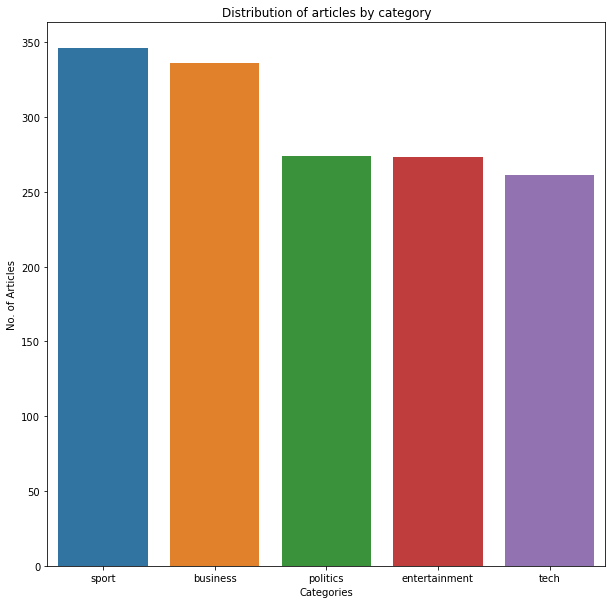

In [18]:
plt.figure(figsize=(10,10))
sns.barplot(x= bbc_train['Category'].value_counts().index, y = bbc_train['Category'].value_counts().values)
plt.title("Distribution of articles by category")
plt.xlabel("Categories")
plt.ylabel('No. of Articles')
plt.show()

### Visualize most frequent words in the train and test dataset that are unimformative and can be discarded in the cleaning stage

the     34992
to      16568
of      12970
and     12366
a       12102
in      11696
s        5899
for      5773
is       5478
that     5207
it       5000
on       4991
was      4019
he       3866
be       3803
with     3482
said     3401
has      3250
as       3245
have     3133
dtype: int64


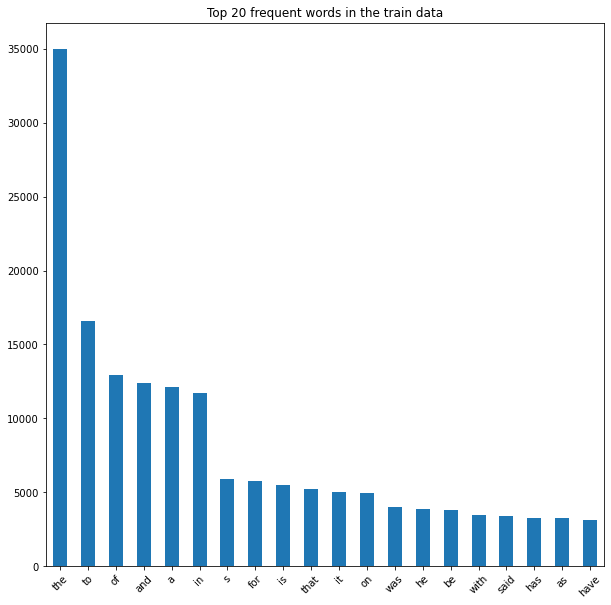

In [19]:
plt.figure(figsize=(10,10))
words = ' '.join(bbc_train["Text"]).split()
w_freq = pd.Series(words).value_counts()
print(w_freq.head(20))
w_freq.head(20).plot(kind='bar')
plt.title("Top 20 frequent words in the train data")
plt.xticks(rotation = 45)
plt.show()

the     17575
to       8387
of       6977
and      6195
a        6149
in       5874
for      3111
s        3108
is       3037
that     2928
it       2584
on       2469
he       2067
was      1997
be       1962
with     1831
as       1731
has      1702
said     1671
have     1612
dtype: int64


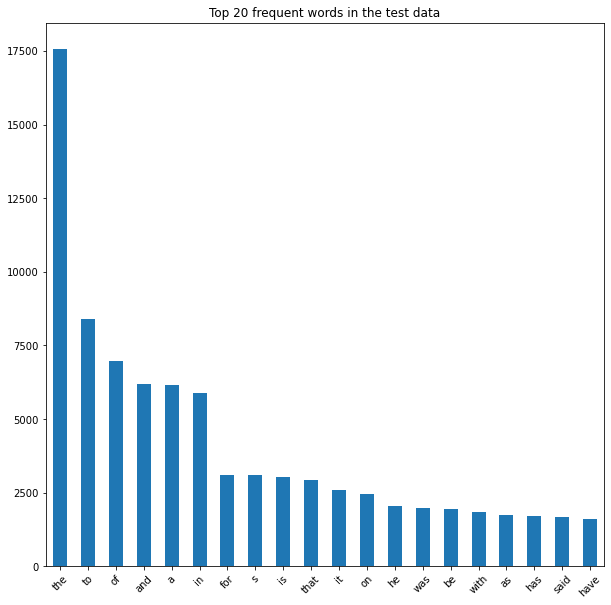

In [20]:
plt.figure(figsize=(10,10))
words = ' '.join(bbc_test["Text"]).split()
w_freq2 = pd.Series(words).value_counts()
print(w_freq2.head(20))
w_freq2.head(20).plot(kind='bar')
plt.title("Top 20 frequent words in the test data")
plt.xticks(rotation = 45)
plt.show()

### Visualize histogram of word count of the documents from train and test data. It is important to count number of words in each article because a low word count article may or may not provide enough imformation.

<Figure size 864x720 with 0 Axes>

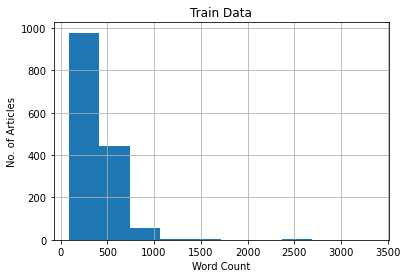

In [21]:
plt.figure(figsize=(12,10))
bbc_train.hist('word_count')
plt.title("Train Data" )
plt.xlabel("Word Count")
plt.ylabel("No. of Articles")
plt.show()

<Figure size 864x720 with 0 Axes>

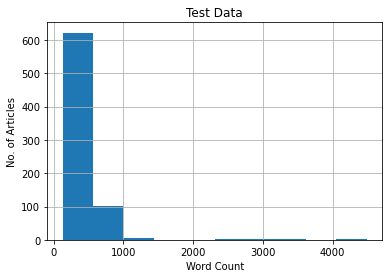

In [22]:
plt.figure(figsize=(12,10))
bbc_test.hist('word_count')
plt.title('Test Data')
plt.xlabel("Word Count")
plt.ylabel("No. of Articles")
plt.show()

### Data Cleaning

### Pre-Processing is an important phase in text processing. The documents extracted from BBC website contains lot of special characters, numbers, urls, hastags and other text which are not necessary for analysis purpose. The quality of the data should be checked before we apply machine learning algorithms to improve computational time. If the text contains a mix of uppercase and lowercase words data analysis becomes difficult. To avoid that we will convert all the text into lowercase. Punctuation or special characters which confuse the ML models should be removed. Numbers can also be removed from the text as they are not important in category classification. A lot of common words calles "stopwords"  such as "a, an, the, is, at,on, my, etc"  which appear within the document sentences would not contribute much to data analysis and thus can be removed. 


In [23]:
def to_lower(text):
   return text.lower()

bbc_train['Clean_Text'] = bbc_train['Text'].apply(to_lower)

bbc_test['Clean_Text'] = bbc_test['Text'].apply(to_lower)

In [24]:
def rem_spec_char(text):
    string = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    
    return string 

bbc_train['Clean_Text'] = bbc_train['Clean_Text'].apply(rem_spec_char)
bbc_test['Clean_Text'] = bbc_test['Clean_Text'].apply(rem_spec_char)

In [25]:
def rem_num(text):
    res = re.sub(r'\d+', '', text)
    return res

bbc_train['Clean_Text'] = bbc_train['Clean_Text'].apply(rem_num)
bbc_test['Clean_Text'] = bbc_test['Clean_Text'].apply(rem_num)

In [26]:
!pip install nltk

import nltk
nltk.download('punkt')
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.6/761.6 kB 124.2 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
stop_words = stopwords.words('english')

def rem_stop_words(text):
    string = " ".join([w for w in text.split() if w not in stop_words] )
    
    return string

bbc_train['Clean_Text'] = bbc_train['Clean_Text'].apply(rem_stop_words)
bbc_test['Clean_Text'] = bbc_test['Clean_Text'].apply(rem_stop_words)



In [28]:
bbc_train.head()

,ArticleId,Text,Category,word_count,Clean_Text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,worldcom exboss launches defence lawyers defen...
1,154,german business confidence slides german busin...,business,325,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,bbc poll indicates economic gloom citizens maj...
3,1976,lifestyle governs mobile choice faster bett...,tech,634,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,355,enron bosses payout eighteen former enron dire...


In [29]:
words = ' '.join(bbc_train["Clean_Text"]).split()
w_freq = pd.Series(words).value_counts()
w_freq_list= w_freq[:10]
print(w_freq_list)

def rem_freq_words(text):
    string = " ".join([w for w in text.split() if w not in w_freq_list] )
    
    return string

bbc_train['Clean_Text'] = bbc_train['Clean_Text'].apply(rem_freq_words)
bbc_test['Clean_Text'] = bbc_test['Clean_Text'].apply(rem_freq_words)



said      4838
mr        1973
would     1711
also      1426
new       1334
people    1322
us        1232
year      1228
one       1158
could     1032
dtype: int64


In [30]:
bbc_train['new_word_count'] = bbc_train['Clean_Text'].apply(lambda n: len(n.split()))
bbc_test['new_word_count'] = bbc_test['Clean_Text'].apply(lambda n: len(n.split()))

In [31]:
bbc_train.head()

,ArticleId,Text,Category,word_count,Clean_Text,new_word_count
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,worldcom exboss launches defence lawyers defen...,169
1,154,german business confidence slides german busin...,business,325,german business confidence slides german busin...,187
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,bbc poll indicates economic gloom citizens maj...,249
3,1976,lifestyle governs mobile choice faster bett...,tech,634,lifestyle governs mobile choice faster better ...,312
4,917,enron bosses in $168m payout eighteen former e...,business,355,enron bosses payout eighteen former enron dire...,195


In [32]:
bbc_test.head()

,ArticleId,Text,word_count,Clean_Text,new_word_count
0,1018,qpr keeper day heads for preston queens park r...,156,qpr keeper day heads preston queens park range...,83
1,1319,software watching while you work software that...,435,software watching work software monitor every ...,226
2,1138,d arcy injury adds to ireland woe gordon d arc...,237,arcy injury adds ireland woe gordon arcy ruled...,134
3,459,india s reliance family feud heats up the ongo...,309,india reliance family feud heats ongoing publi...,172
4,1020,boro suffer morrison injury blow middlesbrough...,135,boro suffer morrison injury blow middlesbrough...,71


### Visualize histogram of new word count of the documents from train and test data after Cleaning. 

<Figure size 864x720 with 0 Axes>

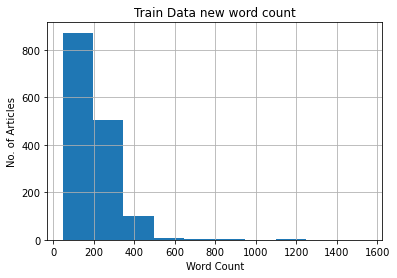

In [33]:
plt.figure(figsize=(12,10))
bbc_train.hist('new_word_count')
plt.title("Train Data new word count" )
plt.xlabel("Word Count")
plt.ylabel("No. of Articles")
plt.show()

In [34]:
bbc_train['new_word_count'].describe()

count    1490.000000
mean      201.335570
std       106.244501
min        46.000000
25%       132.000000
50%       177.500000
75%       245.000000
max      1548.000000
Name: new_word_count, dtype: float64

<Figure size 864x720 with 0 Axes>

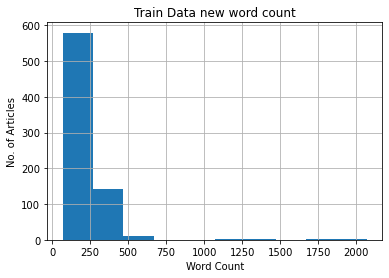

In [35]:
plt.figure(figsize=(12,10))
bbc_test.hist('new_word_count')
plt.title("Train Data new word count" )
plt.xlabel("Word Count")
plt.ylabel("No. of Articles")
plt.show()

In [36]:
bbc_test['new_word_count'].describe()

count     735.000000
mean      208.395918
std       139.798443
min        68.000000
25%       131.500000
50%       179.000000
75%       255.000000
max      2070.000000
Name: new_word_count, dtype: float64

## Feature Extraction
### After the data is cleaned, it should be converted into numerical fromat for machine to understand. This is called feature extraction of document data. Here we will be using one of the many feature extraction techniques:TF-IDF
### TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. Normalizing the word counts reduces the importance of frequent words. A common way is to divide each word count by the log of the total number of instances in which the word appears. If a word appears often in a document, but not in all other documents in the dataset, it is likely to be an important content of that document. By using TfidfVectorizer, we consider overall document weightage of a word by measuring how often they appear in the documents.The words with higher scores of weight are deemed to be more significant. We will now apply tfidfvectorizer to the cleaned train data.


In [37]:
# vectorizer 
tfidf = TfidfVectorizer(max_df= 0.95,min_df= 5,stop_words = 'english')
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=None,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [38]:
# vectors
train_mat = tfidf.fit_transform(bbc_train['Clean_Text'])
train_mat

<1490x6907 sparse matrix of type '<class 'numpy.float64'>'
	with 169355 stored elements in Compressed Sparse Row format>

## Step 2 : Building and training models(Unsupervised)

###  Now we will build our  model using an unsupervised approach called non-negative matrix factorization(NMF) method on the train data to predict the labels, and then test our model performance by feeding it to the test data. Training the model on the test data with lead to overfitting and results will be biased. 

In [39]:
num = len(bbc_train.Category.unique()) #5
y_train =bbc_train['Category']
# Let's build the nmf model on train data
nmf_model = NMF(n_components = num,random_state=1234).fit(train_mat,y_train)
nmf_model

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=1234, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [40]:
# W & H matrices
W = nmf_model.transform(train_mat)
#(1490, 5)
H = nmf_model.components_
#(5, 7055)

# predicted categories
y_pred = np.argmax(W,axis=1)

bbc_train['pred_cat'] = y_pred

In [41]:
! pip install mglearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 101.4 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [42]:
import mglearn
sorted_terms = np.argsort(H, axis=1)[:,::-1]
#vocabulary
vocab = np.array(tfidf.get_feature_names())
#print(feature_names.shape) #(7055,)
mglearn.tools.print_topics(topics=range(num), feature_names= vocab, sorting=sorted_terms, topics_per_chunk=5, n_words=15)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
england       labour        bn            film          mobile        
game          election      growth        best          music         
win           blair         economy       awards        phone         
wales         brown         bank          award         technology    
ireland       party         market        actor         digital       
cup           government    sales         actress       users         
players       minister      economic      films         phones        
play          prime         oil           festival      software      
team          howard        china         director      microsoft     
chelsea       tax           shares        oscar         broadband     
france        chancellor    firm          comedy        net           
world         tory          dollar        aviator       use           
coach 

### From the above results, looking at the words in each topic, we can manually label the topics with the given categories. Topic 0 has words that mostly relate to sports, topic 1 has words related to politics, topic 2 has words related to  business, topic 3 has words related to entertainment, and topic 4 has words related to tech. We will now map the labels to the topic indices in a dictionary. 

In [43]:
topic_dict = {0:'sport', 1:'politics', 2: 'business', 3:'entertainment', 4:'tech'}


In [44]:
bbc_train['pred_cat'] = bbc_train['pred_cat'].map(topic_dict)
bbc_train.head()

,ArticleId,Text,Category,word_count,Clean_Text,new_word_count,pred_cat
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,worldcom exboss launches defence lawyers defen...,169,business
1,154,german business confidence slides german busin...,business,325,german business confidence slides german busin...,187,business
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,bbc poll indicates economic gloom citizens maj...,249,business
3,1976,lifestyle governs mobile choice faster bett...,tech,634,lifestyle governs mobile choice faster better ...,312,tech
4,917,enron bosses in $168m payout eighteen former e...,business,355,enron bosses payout eighteen former enron dire...,195,business


In [45]:
# Calculate the accuracy
acc = accuracy_score( bbc_train['Category'],bbc_train['pred_cat'] )
acc

0.9369127516778524

In [46]:
confusion_matrix(bbc_train['Category'], bbc_train['pred_cat'])

array([[319,   1,   4,   1,  11],
       [  4, 236,   2,   2,  29],
       [ 16,   0, 250,   3,   5],
       [  2,   2,   1, 341,   0],
       [  2,   4,   1,   4, 250]])

In [47]:
# Calculate the accuracy for each category
accuracy_by_category = bbc_train.groupby('Category').apply(lambda x: (x['pred_cat'] == x['Category']).mean())

# Show the accuracy for each category
print("Accuracy per category:")
print(accuracy_by_category)


Accuracy per category:
Category
business         0.949405
entertainment    0.864469
politics         0.912409
sport            0.985549
tech             0.957854
dtype: float64


### I have build a default NMF model on the train data without tuning any parameters and got an accuracy of 0.9369

### Let's work on the test data set

In [48]:
bbc_test.head()

,ArticleId,Text,word_count,Clean_Text,new_word_count
0,1018,qpr keeper day heads for preston queens park r...,156,qpr keeper day heads preston queens park range...,83
1,1319,software watching while you work software that...,435,software watching work software monitor every ...,226
2,1138,d arcy injury adds to ireland woe gordon d arc...,237,arcy injury adds ireland woe gordon arcy ruled...,134
3,459,india s reliance family feud heats up the ongo...,309,india reliance family feud heats ongoing publi...,172
4,1020,boro suffer morrison injury blow middlesbrough...,135,boro suffer morrison injury blow middlesbrough...,71


In [49]:
# Vectorize the testset data with tf-idf
test_mat = tfidf.transform(bbc_test['Clean_Text'])

# predicted categories of the test data
W_t = nmf_model.transform(test_mat)
y_pred_t = W_t.argmax(axis=1)
bbc_test['Category'] = y_pred_t

In [50]:
bbc_test['Category'] = bbc_test['Category'].map(topic_dict)
bbc_test.head()

,ArticleId,Text,word_count,Clean_Text,new_word_count,Category
0,1018,qpr keeper day heads for preston queens park r...,156,qpr keeper day heads preston queens park range...,83,sport
1,1319,software watching while you work software that...,435,software watching work software monitor every ...,226,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,237,arcy injury adds ireland woe gordon arcy ruled...,134,sport
3,459,india s reliance family feud heats up the ongo...,309,india reliance family feud heats ongoing publi...,172,business
4,1020,boro suffer morrison injury blow middlesbrough...,135,boro suffer morrison injury blow middlesbrough...,71,sport


In [51]:
results = bbc_test.drop(columns=['Text','word_count', 'Clean_Text','new_word_count'])
results.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


In [52]:
# Make submission
results.to_csv('submission.csv', index=False)
# Test Score: 0.95374

### After submitting the csv file of the testset data results to Kaggle,I got an accuracy of 0.95374

### Using a function to test all possible combinations of the categories and find out which combination yields maximum score which can be useful for hyperparameter tuning.

In [53]:
def get_accuracy(y_true, y_pred):
    u = np.unique(y_true)  #print(u) ['business' 'entertainment' 'politics' 'sport' 'tech']
    #y_pred = np.argmax(y_pred, axis=1)
    true = y_true.values
    acc = 0
    dict={}
    
    for i in itertools.permutations(range(len(u))): 
        comb = np.array([u[i.index(x)] for x in y_pred])        
        score = np.mean(comb == true)  
        acc = max(acc,score)
        dict[i] = score
        b = max( dict.items(), key = operator.itemgetter(1))[0]
        topic_d =dict.fromkeys(b)
        for k,v in zip(topic_d.keys(),u):
            topic_d[k] =v
        
    k =list(topic_d.keys()) 
    v = list(topic_d.values())
    index = np.argsort(k)
    sorted_dict={k[i]:v[i] for i in index}   
    
    return acc, sorted_dict


In [54]:
#acc_score= get_accuracy(y_train,results)
acc_score, best_comb = get_accuracy(y_train,y_pred)

print("accuracy=", acc_score)
print("Best Combination=", best_comb)

accuracy= 0.9369127516778524
Best Combination= {0: 'sport', 1: 'politics', 2: 'business', 3: 'entertainment', 4: 'tech'}



### Let's tune the hyperparameter(s) of the NMF model and record the results of the train data.

In [55]:
h_param_tuning_results = pd.DataFrame(columns = ['Alpha', 'L1_Ratio','Init','Solver,','Beta_Loss','Combination','Accuracy'])
alpha =[0, 0.5,1]
l1_ratio=[0, 0.5,1]
init_nmf = [None,"random", "nndsvda"]

for a in alpha:
    for l1 in l1_ratio :
        for init in init_nmf:            
                    nmf = NMF( n_components = 5, 
                               solver= "mu",
                               beta_loss= "kullback-leibler",                              
                               alpha = a,
                               l1_ratio=l1 , 
                               init=init,
                               random_state=123)
                
                    W = nmf.fit_transform(train_mat)
                    y_pred = np.argmax(W,axis=1)
                    acc, best_comb = get_accuracy(y_train,y_pred)
                    h_param_tuning_results.loc[len(h_param_tuning_results.index)] = [a, l1, init,"mu","kullback-leibler",best_comb, round(acc, 4)]


#h_param_tuning_results 
sorted_df = h_param_tuning_results.sort_values(by='Accuracy', ascending=False)
sorted_df

,Alpha,L1_Ratio,Init,"Solver,",Beta_Loss,Combination,Accuracy
26,1,1,nndsvda,mu,kullback-leibler,"{0: 'sport', 1: 'politics', 2: 'business', 3: ...",0.9503
14,0.5,0.5,nndsvda,mu,kullback-leibler,"{0: 'sport', 1: 'politics', 2: 'business', 3: ...",0.9503
23,1,0.5,nndsvda,mu,kullback-leibler,"{0: 'sport', 1: 'politics', 2: 'business', 3: ...",0.9503
17,0.5,1,nndsvda,mu,kullback-leibler,"{0: 'sport', 1: 'politics', 2: 'business', 3: ...",0.9503
11,0.5,0,nndsvda,mu,kullback-leibler,"{0: 'sport', 1: 'politics', 2: 'business', 3: ...",0.9497
2,0,0,nndsvda,mu,kullback-leibler,"{0: 'sport', 1: 'politics', 2: 'business', 3: ...",0.9490
5,0,0.5,nndsvda,mu,kullback-leibler,"{0: 'sport', 1: 'politics', 2: 'business', 3: ...",0.9490
20,1,0,nndsvda,mu,kullback-leibler,"{0: 'sport', 1: 'politics', 2: 'business', 3: ...",0.9490
8,0,1,nndsvda,mu,kullback-leibler,"{0: 'sport', 1: 'politics', 2: 'business', 3: ...",0.9490
12,0.5,0.5,None,mu,kullback-leibler,"{0: 'sport', 1: 'politics', 2: 'business', 3: ...",0.9463


### From the above table, we can see improvement in model performance (accuracy ~ 0.95) with the given parameters. The best accuracy is when $init='nndsvda'$, $solver= "mu"$, $beta_loss= 'kullback-leibler'$ and when $apha$ and $l1_ratio$ values are 0.5 and 1. When $init= 'random'$ , the accuracy falls to 0.75 because the combinations are changed. 

In [56]:
# best NMF model 

NMF_model = NMF(n_components =5,init='nndsvda',solver='mu', beta_loss='kullback-leibler',
                alpha=0.5, l1_ratio= 1,random_state=1234).fit(train_mat,y_train)

# W & H matrices
W = NMF_model.transform(train_mat)
H = NMF_model.components_

# predicted categories of train data
y_pred1 = np.argmax(W,axis=1)
 
#Accuracy score of train data
acc_score, best_comb = get_accuracy(y_train, y_pred1)
print("Train accuracy=", round(acc_score,4))

# Vectorize the testset data with tf-idf
test_mat = tfidf.transform(bbc_test['Clean_Text'])

# predicted categories of the test data
W_t = nmf_model.transform(test_mat)
y_pred_t = W_t.argmax(axis=1)
bbc_test['Category'] = y_pred_t
bbc_test['Category'] = bbc_test['Category'].map(topic_dict)

# Make submission
results.to_csv('submission.csv', index=False)

Train accuracy= 0.9503


### After fitting the train data with the best NMf model and submitting the csv file of the testset data results to Kaggle,I still got an accuracy of 0.95374.

## Step 3: Compare with supervised learning 

### 1. Logistic Regression 

In [57]:
# Logistic Regression
lg_model = LogisticRegression().fit(train_mat, y_train)
print(lg_model)

# Prediction
lg_train_pred = lg_model.predict(train_mat)
lg_train_accuracy = accuracy_score(y_train, lg_train_pred)
print('Accuracy of training set without hyperparameter tuning: ', lg_train_accuracy)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy of training set without hyperparameter tuning:  0.9959731543624161


In [74]:
# Hyper-Parameter Tuning

lg_param_grid = {"penalty": ["l1", "l2"], 
                  "C": [0.01, 0.1, 1, 3, 10], 
                  "solver": ["liblinear"]}

lg_grid = sklearn.model_selection.GridSearchCV(estimator=sklearn.linear_model.LogisticRegression(),
                                                param_grid=lg_param_grid, 
                                                scoring="accuracy", n_jobs=-1, cv=5)
lg_grid.fit(train_mat, y_train)
print(lg_grid.best_estimator_)
best_lg_model = lg_grid.best_estimator_.fit(train_mat, y_train)
best_lg_model.score(train_mat, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


1.0

### 2. Random Forest


In [59]:
# Random Forest Classifier
rf_model = RandomForestClassifier().fit(train_mat, y_train)
print(rf_model)

# Prediction
train_pred = rf_model.predict(train_mat)
rf_train_accuracy = accuracy_score(y_train, train_pred)
print('Accuracy of training set without hyperparameter tuning: ',rf_train_accuracy)



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy of training set without hyperparameter tuning:  1.0


In [60]:
# Hyper-Parameter Tuning

rf_param_grid = {"n_estimators": [100, 200, 300, 500], 
                 "max_depth": [2, 3, 5, 10, 20]}

rf_grid = sklearn.model_selection.GridSearchCV(estimator=sklearn.ensemble.RandomForestClassifier(), 
                                               param_grid=rf_param_grid, scoring="accuracy", n_jobs=-1, cv=5)
rf_grid.fit(train_mat, y_train)
print(rf_grid.best_estimator_)
best_rf_model = rf_grid.best_estimator_.fit(train_mat, y_train)
best_rf_model.score(train_mat, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


0.9986577181208054

### Test the performance of Logistic Regression and Random Forest Classifer on the test data to get the accuracy score.


In [61]:
lg_test = best_lg_model.predict(test_mat)

rf_test = best_rf_model.predict(test_mat)

results_log = pd.DataFrame( zip(bbc_test['ArticleId'],lg_test), columns=["ArticleId", "Category"])

results_rf = pd.DataFrame( zip(bbc_test['ArticleId'],rf_test), columns=["ArticleId", "Category"])

In [62]:
results_log.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


In [63]:
results_log.to_csv('submission1.csv',index=False) #Test Score: 0.97959

In [64]:
results_rf.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


In [65]:
results_rf.to_csv('submission2.csv',index=False) #Test Score: 0.96598

### AFter submitting the results to Kaggle, I got a test accuracy score of 0.97959 for the logistic regression model and 0.96598 gor random forest model.

### Comparision of 3 models 

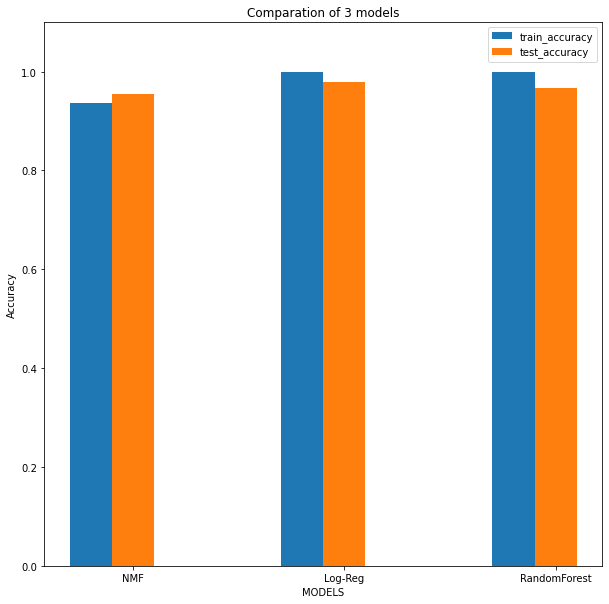

In [66]:
train_acc=[0.9369,1,0.9993]
test_acc= [0.95374, 0.9796,0.9659]
labels = ['NMF','Log-Reg', 'RandomForest']

fig,ax = plt.subplots(figsize=(10,10))
width_1 = 0.2
plt.ylim([0.0, 1.1])
ax.set_xlabel('MODELS')
ax.set_ylabel('Accuracy')
ax.set_title('Comparation of 3 models')
ax.bar(np.arange(len(train_acc)), train_acc, width=width_1, tick_label=labels, label = "train_accuracy")
ax.bar(np.arange(len(test_acc))+width_1, test_acc, width=width_1, tick_label=labels, label="test_accuracy")
ax.legend()
plt.show()

### From the above visualization, log-regression model seems to perform well on the data. Next is the random forest model. Supervised models seem to fit the data well than unsuprvised model here.

### Now we will fit the unsupervised NMF model and the above 2 supervised models on different subsets of training data and compare the results

In [69]:
X = bbc_train['Clean_Text']
y = bbc_train['Category']

# subset ratios of training data
ratio = [0.1, 0.2, 0.5,0.8]

for r in ratio: 
    # Split the train data 
    X_train, X_val, y_train1, y_val = train_test_split(X, y, train_size = r, random_state=1)
    # Vectorize X_train and X_test
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf =  tfidf.transform(X_val)
    
    # NMF model
    print("1.NMF_MODEL:\n")
    NMF_model = NMF(n_components =5,init='nndsvda',solver='mu', beta_loss='kullback-leibler',
                alpha=0.5, l1_ratio= 1,random_state=1234).fit(X_train_tfidf,y_train1)

    # W & H matrices
    W = NMF_model.transform(X_train_tfidf)
    H = NMF_model.components_
    # predicted categories of train data
    y_pred1 = np.argmax(W,axis=1)
    #Accuracy score of train data
    acc_score, best_comb = get_accuracy(y_train1, y_pred1)
    print("Train accuracy for", r*100,"% of the train data =", round(acc_score,4))
    # predicted categories of the test data
    W_t = NMF_model.transform(X_test_tfidf)
    y_pred_t = W_t.argmax(axis=1)
    #Accuracy score of test data
    acc_score, best_com1 = get_accuracy(y_val, y_pred_t)
    print("Test accuracy for", r*100,"% of the train data =", round(acc_score,4), "\n")

    #Log-regression model
    print("2.LOG-REGRESSION_MODEL:\n")
    
    lg_model = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False).fit(X_train_tfidf,y_train1)
    #LogisticRegression().fit(X_train_tfidf,y_train1)
    # Prediction
    lg_train_pred = lg_model.predict(X_train_tfidf)
    lg_train_accuracy = accuracy_score(y_train1, lg_train_pred)
    print("Train accuracy for", r*100,"% of the train data =", round(lg_train_accuracy, 4))
    lg_test_pred = lg_model.predict(X_test_tfidf)
    lg_test_accuracy = accuracy_score(y_val, lg_test_pred)
    print("Test accuracy for", r*100,"% of the train data =", round(lg_test_accuracy,4),"\n")
    
    # Random Forest Model
    print("3.RANDOM_FOREST_MODEL:\n")
    rf_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False).fit(X_train_tfidf,y_train1)
    #RandomForestClassifier().fit(X_train_tfidf,y_train1)
    # Prediction
    rf_train_pred = rf_model.predict(X_train_tfidf)
    rf_train_accuracy = accuracy_score(y_train1, rf_train_pred)
    print("Train accuracy for", r*100,"% of the train data =", round(rf_train_accuracy, 4))
    rf_test_pred = rf_model.predict(X_test_tfidf)
    rf_test_accuracy = accuracy_score(y_val, rf_test_pred)
    print("Test accuracy for", r*100,"% of the train data =", round(rf_test_accuracy,4),"\n")
    print("-----------------------------------------------")
    


1.NMF_MODEL:

Train accuracy for 10.0 % of the train data = 0.6443
Test accuracy for 10.0 % of the train data = 0.6689 

2.LOG-REGRESSION_MODEL:

Train accuracy for 10.0 % of the train data = 1.0
Test accuracy for 10.0 % of the train data = 0.9113 

3.RANDOM_FOREST_MODEL:

Train accuracy for 10.0 % of the train data = 1.0
Test accuracy for 10.0 % of the train data = 0.8307 

-----------------------------------------------
1.NMF_MODEL:

Train accuracy for 20.0 % of the train data = 0.9362
Test accuracy for 20.0 % of the train data = 0.9371 

2.LOG-REGRESSION_MODEL:

Train accuracy for 20.0 % of the train data = 1.0
Test accuracy for 20.0 % of the train data = 0.9589 

3.RANDOM_FOREST_MODEL:

Train accuracy for 20.0 % of the train data = 1.0
Test accuracy for 20.0 % of the train data = 0.9153 

-----------------------------------------------
1.NMF_MODEL:

Train accuracy for 50.0 % of the train data = 0.9544
Test accuracy for 50.0 % of the train data = 0.953 

2.LOG-REGRESSION_MODEL:

Tra

### Summary Table of all 3 models on different subsets of data

In [73]:

data = {'NMF': [0.9503,0.9537,0.6443, 0.6689,0.9362,0.9371,0.9544,0.9530,0.9505,0.9497],
        'LR' : [1.0,0.9796,1.0, 0.9113,1.0,0.9589,1.0,0.9718,1.0,0.9866],
        'RF' : [0.9986,0.9659,1.0, 0.8374,1.0,0.9161,1.0,0.9517,0.9992,0.9597]}

df=pd.DataFrame(data, 
                index= ['Train_actual','Test_actual','Train_10%','Test_10%','Train_20%','Test_20%', 'Train_50%', 'Test_50%','Train_80%','Test_80%'])

df

,NMF,LR,RF
Train_actual,0.9503,1.0000,0.9986
Test_actual,0.9537,0.9796,0.9659
Train_10%,0.6443,1.0000,1.0000
Test_10%,0.6689,0.9113,0.8374
Train_20%,0.9362,1.0000,1.0000
Test_20%,0.9371,0.9589,0.9161
Train_50%,0.9544,1.0000,1.0000
Test_50%,0.9530,0.9718,0.9517
Train_80%,0.9505,1.0000,0.9992
Test_80%,0.9497,0.9866,0.9597


## Conclusions:
### As a part of exploratory data analysis, both the train and test data are inspected, visualized and cleaned in the preprocessing stage to prepare for modeling. Before the modeling stage, the data is first transformed into a vector from using TFIDF method since we are working on the text data here. The vectorized data is modeled using unsupervised and supervised approach. 

### Overall, from the above summary table dataframe the first 2 rows are the actual train set(1490) and test set(735) results and the rest are subsets of train data. All the three models perform well but out of 3, supervised models predict data more accurately since they work well on labeled data to predict efficient results. Unsupervised models take several iterations to get better results.

### On different subsets of train data, the performance of the NMF model is less when train data is 10% and improves when data is more than 20%. Whereas for the other 2 supervised models, high train score than test score for all subsets of data show there may be overfitting.

### We can further improve the performace of the NMF model by using advanced stemming, tokenziation and lemmatization techniques from spacy instead of simple text processing mthods such as tfidfvectorizer and countvectorizer from scikit.


## Reference list:
https://www.wevolver.com/article/unsupervised-vs-supervised-learning-a-comprehensive-comparison
https://towardsdatascience.com/non-negative-matrix-factorization-nmf-for-dimensionality-reduction-in-image-data-8450f4cae8fa
https://www.searchenginejournal.com/topic-clusters-recommender-system/436123/
https://www.analyticsvidhya.com/blog/2021/09/creating-a-movie-reviews-classifier-using-tf-idf-in-python/